In [ ]:
!pip install kaggle -q
!pip install tensorflow -q
!pip install imbalanced-learn -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d mlg-ulb/creditcardfraud
!unzip creditcardfraud.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
  0% 0.00/66.0M [00:00<?, ?B/s]
100% 66.0M/66.0M [00:00<00:00, 846MB/s]
Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [ ]:
df = pd.read_csv("creditcard.csv")
print(df.head())
print("\nClass Distribution:\n", df["Class"].value_counts())
print("\nMissing Values:\n", df.isnull().sum())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

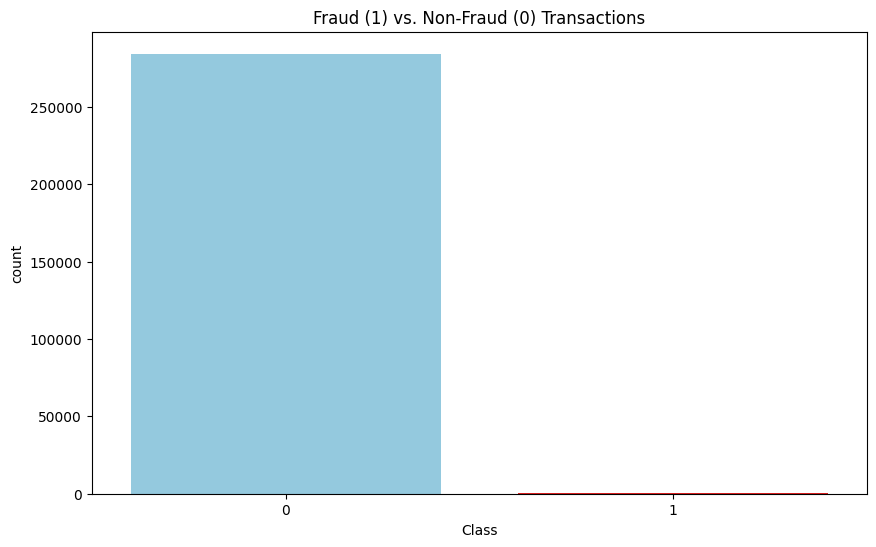

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="Class", hue="Class", palette={0: "skyblue", 1: "red"}, legend=False)
plt.title("Fraud (1) vs. Non-Fraud (0) Transactions")
plt.show()


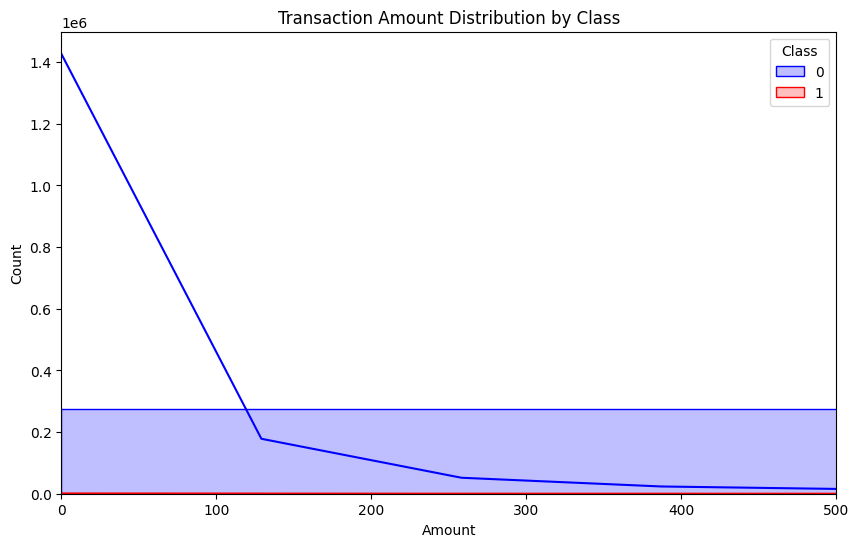

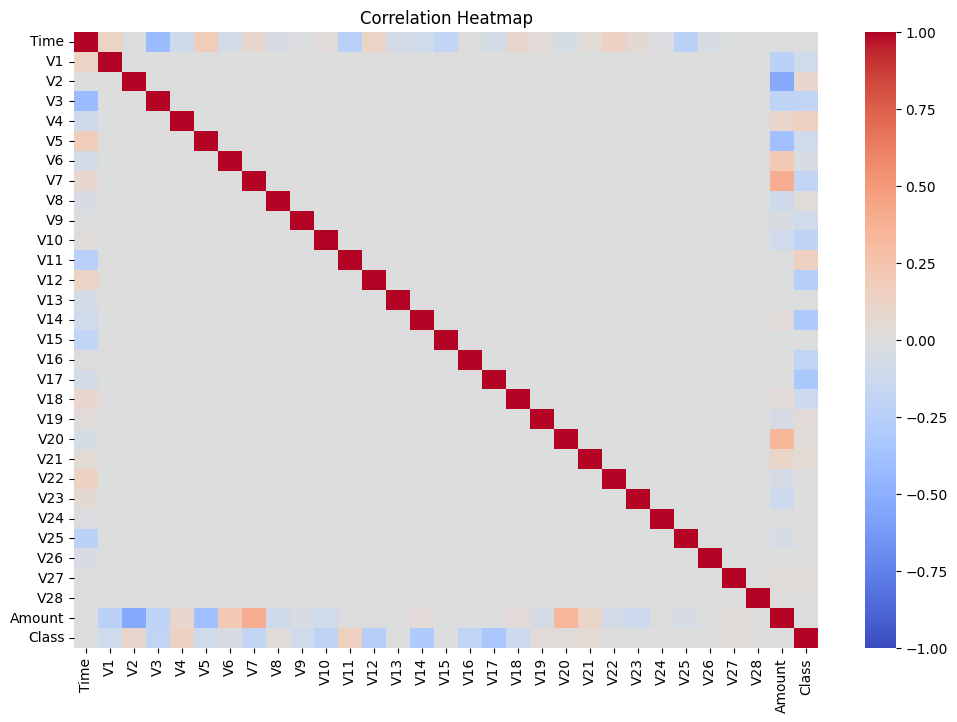

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="Amount", hue="Class",
             bins=50, palette=["blue", "red"],
             kde=True, element="step")
plt.xlim(0, 500)
plt.title("Transaction Amount Distribution by Class")
plt.show()

# Correlation heatmap remains the same
plt.figure(figsize=(12, 8))
corr = df.corr()
sns.heatmap(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
scaler = StandardScaler()
df["Normalized_Amount"] = scaler.fit_transform(df["Amount"].values.reshape(-1, 1))
df.drop(["Amount", "Time"], axis=1, inplace=True)

X = df.drop("Class", axis=1)
y = df["Class"]

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)

In [ ]:
model = Sequential([
    Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)


In [ ]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=256,
    callbacks=[EarlyStopping(monitor="val_auc", patience=5, restore_best_weights=True)],
    verbose=1
)

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.6332 - auc: 0.6867 - loss: 0.6847 - val_accuracy: 0.5190 - val_auc: 0.9665 - val_loss: 0.6807
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7286 - auc: 0.8214 - loss: 0.5362 - val_accuracy: 0.5190 - val_auc: 0.9691 - val_loss: 0.6359
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7825 - auc: 0.8682 - loss: 0.4680 - val_accuracy: 0.5190 - val_auc: 0.9705 - val_loss: 0.5942
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8219 - auc: 0.9086 - loss: 0.3965 - val_accuracy: 0.5190 - val_auc: 0.9719 - val_loss: 0.5547
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8257 - auc: 0.9097 - loss: 0.3944 - val_accuracy: 0.5380 - val_auc: 0.9730 - val_loss: 0.5178
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8406 - auc: 0.9241 - loss: 0.3745 - val_accuracy: 0.5759 - val_auc: 0.9741 - val_loss: 0.4831
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accura

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


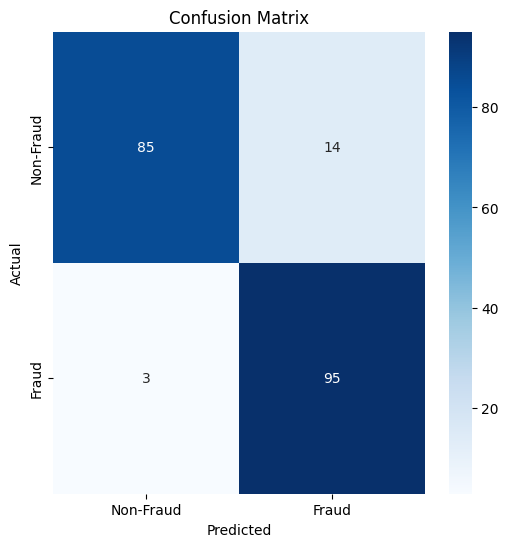

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
              precision    recall  f1-score   support

           0       0.97      0.86      0.91        99
           1       0.87      0.97      0.92        98

    accuracy                           0.91       197
   macro avg       0.92      0.91      0.91       197
weighted avg       0.92      0.91      0.91       197



In [ ]:
#confusion matrix visualization
plt.figure(figsize=(6, 6))
cm = confusion_matrix(y_test, (model.predict(X_test) > 0.5).astype(int))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_test, (model.predict(X_test) > 0.5).astype(int)))

**Risk Prediction Visualization**

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


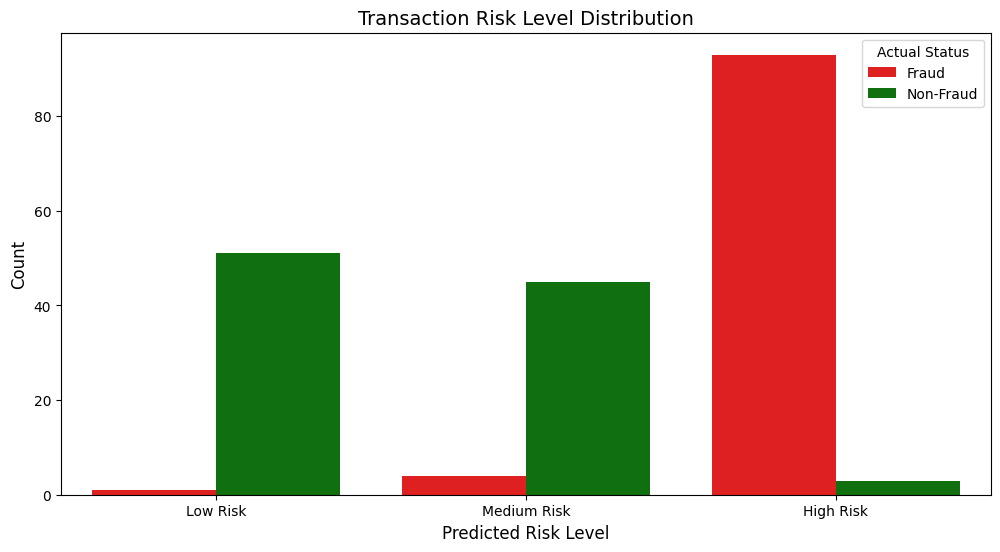

In [ ]:
y_pred_proba = model.predict(X_test)

# Create risk assessment DataFrame
risk_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted_Probability': y_pred_proba.flatten()
})

# Categorize risk levels
risk_df['Risk_Level'] = pd.cut(risk_df['Predicted_Probability'],
                              bins=[0, 0.3, 0.7, 1],
                              labels=['Low Risk', 'Medium Risk', 'High Risk'])

# Map actual values to labels
risk_df['Actual_Label'] = risk_df['Actual'].map({0: 'Non-Fraud', 1: 'Fraud'})

# Visualize risk distribution
plt.figure(figsize=(12, 6))
sns.countplot(
    data=risk_df,
    x='Risk_Level',
    hue='Actual_Label',
    palette={'Non-Fraud': 'green', 'Fraud': 'red'},
    order=['Low Risk', 'Medium Risk', 'High Risk']
)
plt.title('Transaction Risk Level Distribution', fontsize=14)
plt.xlabel('Predicted Risk Level', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Actual Status')
plt.show()

Enhanced Risk-Reward Decision **Matrix**

<ipython-input-19-a96802c66aee>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  decision_matrix = risk_df.groupby(['Risk_Level', 'Actual_Label']).size().unstack()


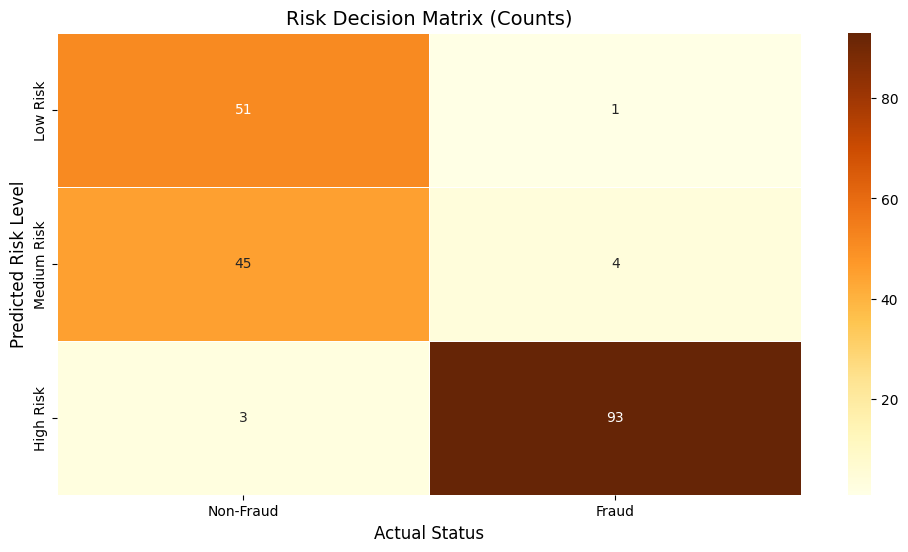

<ipython-input-19-a96802c66aee>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


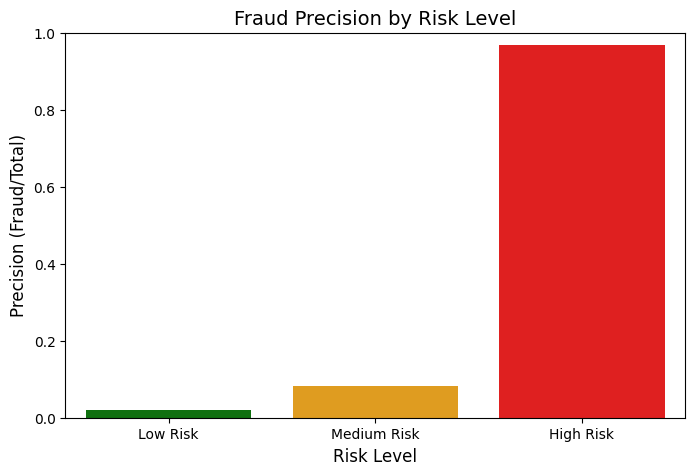

In [ ]:
# Create decision matrix
decision_matrix = risk_df.groupby(['Risk_Level', 'Actual_Label']).size().unstack()

# Calculate precision
decision_matrix['Precision'] = decision_matrix['Fraud'] / (decision_matrix['Fraud'] + decision_matrix['Non-Fraud'])

# Visualize decision matrix
plt.figure(figsize=(12, 6))
sns.heatmap(
    decision_matrix[['Non-Fraud', 'Fraud']],
    annot=True,
    fmt='d',
    cmap='YlOrBr',
    linewidths=.5
)
plt.title('Risk Decision Matrix (Counts)', fontsize=14)
plt.xlabel('Actual Status', fontsize=12)
plt.ylabel('Predicted Risk Level', fontsize=12)
plt.show()

# Visualize precision
plt.figure(figsize=(8, 5))
sns.barplot(
    x=decision_matrix.index,
    y=decision_matrix['Precision'],
    palette=['green', 'orange', 'red']
)
plt.title('Fraud Precision by Risk Level', fontsize=14)
plt.xlabel('Risk Level', fontsize=12)
plt.ylabel('Precision (Fraud/Total)', fontsize=12)
plt.ylim(0, 1)
plt.show()

**Transaction Categorization Heatmap**

<ipython-input-23-e82e1b533ceb>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  transaction_analysis = df.groupby('Amount_Category').agg({


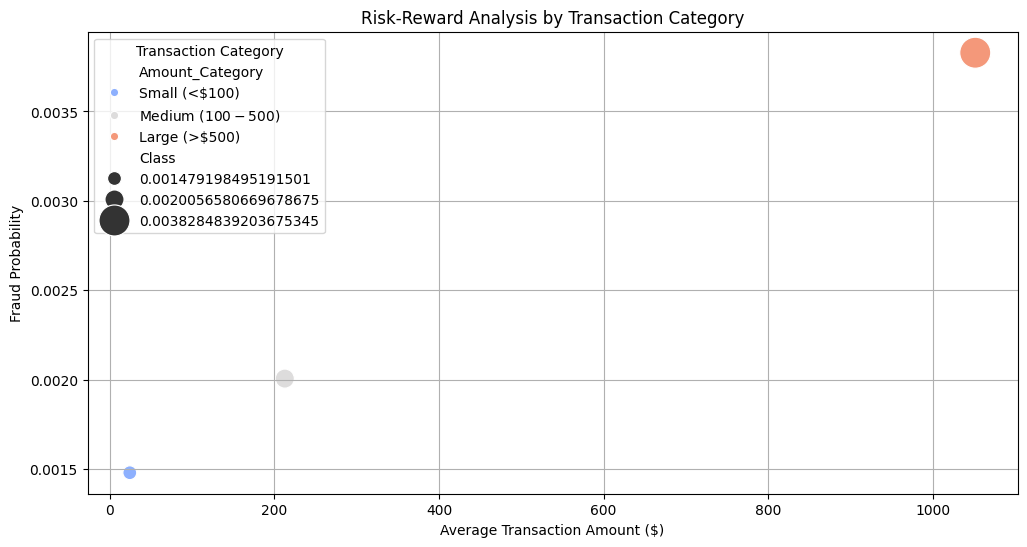

In [ ]:
# Calculate risk-reward ratios
transaction_analysis = df.groupby('Amount_Category').agg({
    'Class': 'mean',  # Fraud rate
    'Normalized_Amount': 'mean'  # Average amount
}).reset_index()

# Convert back to original amount scale
transaction_analysis['Avg_Amount'] = (transaction_analysis['Normalized_Amount'] *
                                    scaler.scale_[0] + scaler.mean_[0])

plt.figure(figsize=(12, 6))
sns.scatterplot(data=transaction_analysis, x='Avg_Amount', y='Class',
                hue='Amount_Category', size='Class', sizes=(100, 500),
                palette='coolwarm')
plt.title('Risk-Reward Analysis by Transaction Category')
plt.xlabel('Average Transaction Amount ($)')
plt.ylabel('Fraud Probability')
plt.grid(True)
plt.legend(title='Transaction Category')
plt.show()

**Cumulative Fraud Detection**

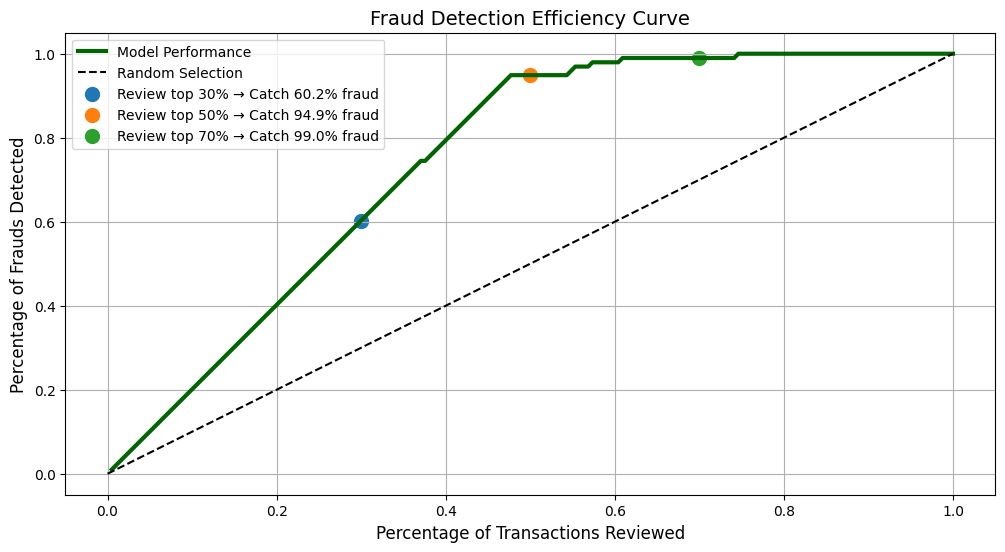

In [ ]:
# Sort test transactions by predicted probability
test_results = pd.DataFrame({
    'Amount': X_test['Normalized_Amount'] * scaler.scale_[0] + scaler.mean_[0],
    'Actual': y_test,
    'Probability': y_pred_proba.flatten()
}).sort_values('Probability', ascending=False)

# Calculate cumulative metrics
test_results['Cum_Fraud'] = test_results['Actual'].cumsum()
test_results['Cum_Percentage'] = np.arange(1, len(test_results)+1) / len(test_results)
total_frauds = test_results['Actual'].sum()

plt.figure(figsize=(12, 6))
plt.plot(
    test_results['Cum_Percentage'],
    test_results['Cum_Fraud']/total_frauds,
    linewidth=3,
    color='darkgreen',
    label='Model Performance'
)
plt.plot(
    [0, 1], [0, 1],
    'k--',
    label='Random Selection'
)

# Add decision thresholds
for threshold in [0.3, 0.5, 0.7]:
    idx = int(len(test_results) * threshold)
    fraud_caught = test_results.iloc[:idx]['Actual'].sum() / total_frauds
    plt.scatter(
        threshold,
        fraud_caught,
        s=100,
        label=f'Review top {threshold:.0%} → Catch {fraud_caught:.1%} fraud'
    )

plt.title('Fraud Detection Efficiency Curve', fontsize=14)
plt.xlabel('Percentage of Transactions Reviewed', fontsize=12)
plt.ylabel('Percentage of Frauds Detected', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

**Training and Validation Accuracy**

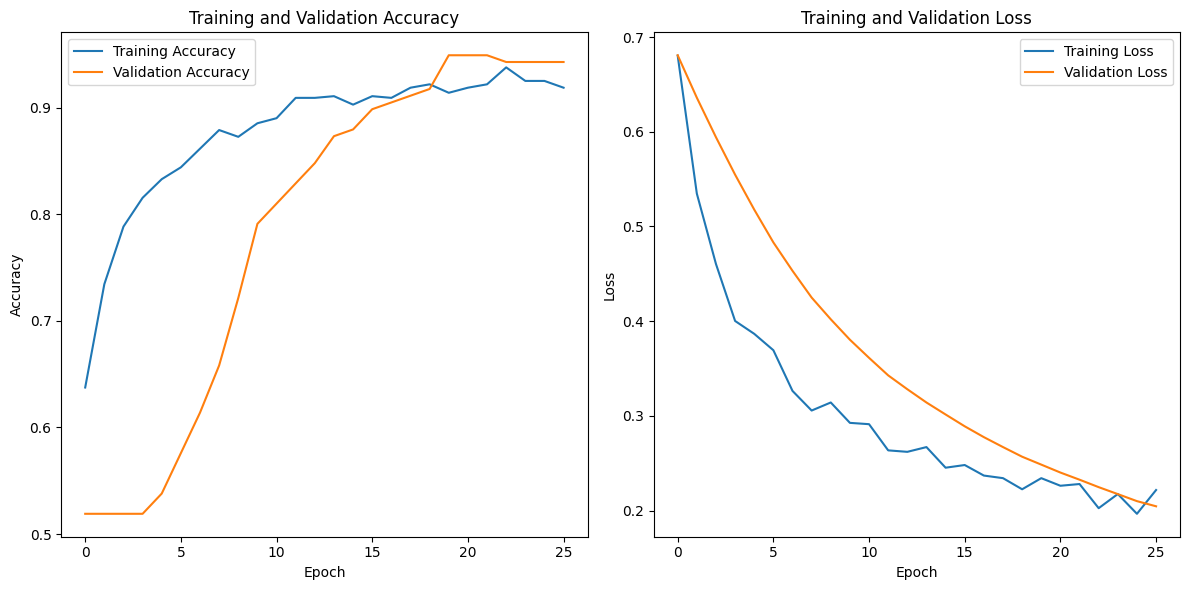


Final Training Accuracy: 0.9189
Final Validation Accuracy: 0.9430


In [ ]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Print final metrics
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]
print(f"\nFinal Training Accuracy: {train_accuracy:.4f}")
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

**Test Set Evaluation**

In [ ]:
# Evaluate on test set
test_loss, test_acc, test_auc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Classification report
y_pred = (model.predict(X_test) > 0.5).astype(int)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))


Test Accuracy: 0.9137
Test AUC: 0.9858
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       0.97      0.86      0.91        99
       Fraud       0.87      0.97      0.92        98

    accuracy                           0.91       197
   macro avg       0.92      0.91      0.91       197
weighted avg       0.92      0.91      0.91       197



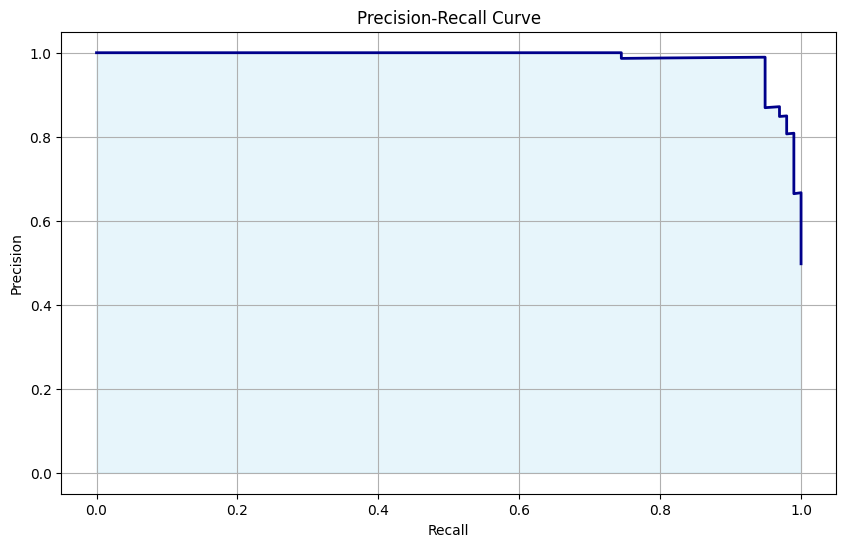

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, linewidth=2, color='darkblue')
plt.fill_between(recall, precision, alpha=0.2, color='skyblue')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

**Final Performance Summary**

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Create summary DataFrame
performance_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'],
    'Training': [train_accuracy, np.nan, np.nan, np.nan, np.nan],
    'Validation': [val_accuracy, np.nan, np.nan, np.nan, np.nan],
    'Test': [test_acc, precision, recall, f1, test_auc]
})

print("\nPerformance Summary:")
print(performance_df.to_markdown(index=False))


Performance Summary:
| Metric    |   Training |   Validation |     Test |
|:----------|-----------:|-------------:|---------:|
| Accuracy  |   0.918919 |     0.943038 | 0.913706 |
| Precision | nan        |   nan        | 0.87156  |
| Recall    | nan        |   nan        | 0.969388 |
| F1-Score  | nan        |   nan        | 0.917874 |
| AUC-ROC   | nan        |   nan        | 0.985828 |
